In [1]:
# Install necessary libraries
!pip install pinecone sentence-transformers flask flask-ngrok pytesseract opencv-python tensorflow duckduckgo_search
!pip install flask pyngrok
!pip install -q ddgs
!sudo apt install tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 15.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [2]:
%%writefile config.py
import os

# --- API KEYS ---
# Replace these with your actual keys
PINECONE_API_KEY = "INPUT YOUR PINECONE_API_KEY"
NGROK_AUTH_TOKEN = "INPUT YOUR NGROK_AUTH_TOKEN"

# --- SETTINGS ---
INDEX_NAME = "ecommerce-product-index"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
DATASET_PATH = "dataset.csv"
CLEAN_DATA_PATH = "dataset_cleaned.csv"
IMAGE_DIR = "dataset_images"
MODEL_PATH = "product_model.h5"
CLASS_NAMES_FILE = "class_names.pkl"

Overwriting config.py


## 2. data_pipeline.py
This handles data cleaning and image scraping. It imports settings from config.py.

In [8]:
%%writefile data_pipeline.py
import pandas as pd
import re
import os
import config # Ensure this is imported as lowercase 'config'

class DataManager:
    def __init__(self):
        self.df = None

    def load_and_clean_data(self):
        """Loads CSV and cleans special characters."""
        print("Loading and cleaning dataset...")
        try:
            self.df = pd.read_csv(config.DATASET_PATH, encoding='ISO-8859-1')
        except UnicodeDecodeError:
            self.df = pd.read_csv(config.DATASET_PATH, encoding='utf-8')

        # 1. Clean StockCode: Remove special chars, BUT KEEP LETTERS (e.g., '85123A')
        # 1. Clean StockCode: Remove special chars like 'ö', '^', etc.
        self.df['StockCode'] = self.df['StockCode'].astype(str).apply(lambda x: re.sub(r'[^A-Za-z0-9]', '', x))
        self.df['StockCode'] = self.df['StockCode'].astype(str).apply(lambda x: re.sub(r'[^\d]', '', x))s.

        # 2. Clean Description
        self.df = self.df.dropna(subset=['Description'])
        self.df['Description'] = self.df['Description'].astype(str).apply(lambda x: x.replace('$', '').strip())

        # 3. Clean Quantity
        self.df['Quantity'] = self.df['Quantity'].astype(str).apply(lambda x: re.sub(r'[^\d-]', '', x))
        self.df['Quantity'] = pd.to_numeric(self.df['Quantity'], errors='coerce').fillna(0).astype(int)

        # 4. Clean UnitPrice
        self.df['UnitPrice'] = self.df['UnitPrice'].astype(str).apply(lambda x: re.sub(r'[^\d\.]', '', x))
        self.df['UnitPrice'] = pd.to_numeric(self.df['UnitPrice'], errors='coerce').fillna(0.0)

        # 5. Clean CustomerID
        self.df['CustomerID'] = self.df['CustomerID'].astype(str).apply(lambda x: re.sub(r'[^\d\.]', '', x))

        # 6. Clean Country
        self.df['Country'] = self.df['Country'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).replace('XxY', '').strip())

        # 7. Clean InvoiceNo (careful not to lose 'C' prefix if it exists)
        # If you are SURE you only want numbers, keep your original line.
         # 7. # Enforce strictly numbers in InvoiceNo
        self.df['InvoiceNo'] = self.df['InvoiceNo'].astype(str).apply(lambda x: re.sub(r'[^\d]', '', x))

        # 8. Remove Duplicates
        self.df = self.df.drop_duplicates()

        # 9. Drop rows containing ANY NaN values
        self.df = self.df.dropna()

        # SAVE cleaned data
        # FIXED: Changed Config.CLEAN_DATA_PATH to config.CLEAN_DATA_PATH
        self.df.to_csv(config.CLEAN_DATA_PATH, index=False)
        print(f"Data cleaned and saved to {config.CLEAN_DATA_PATH}. Shape: {self.df.shape}")
        return self.df


Overwriting data_pipeline.py


In [9]:
# 1. Import the class from the file you created
from data_pipeline import DataManager
import config

# 2. Now the notebook knows what 'DataManager' is
pipeline = DataManager()
pipeline.load_and_clean_data()

Loading and cleaning dataset...
Data cleaned and saved to dataset_cleaned.csv. Shape: (535616, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [5]:
%%writefile image_pipeline.py
import os
import time
import requests
import pandas as pd
import re
# from duckduckgo_search import DDGS
from ddgs import DDGS  # Changed from duckduckgo_search
from PIL import Image
import config

class ImageScraper:
    def __init__(self, save_dir=config.IMAGE_DIR):
        self.save_dir = save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    def download_images(self, query, num_images=50):
        """Download images with enhanced error handling and debugging."""
        safe_query = re.sub(r'[^\w\s-]', '', query).strip()
        folder_path = os.path.join(self.save_dir, safe_query)

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        print(f"\n{'='*60}")
        print(f"Searching for: '{query}'")
        print(f"Folder: {folder_path}")

        # Check if folder already has enough images
        existing_images = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
        if existing_images >= num_images:
            print(f"✓ Already have {existing_images} images, skipping...")
            return existing_images

        results = []
        try:
            # Try with context manager
            with DDGS() as ddgs:
                results = list(ddgs.images(query, max_results=num_images))
                print(f"Found {len(results)} image URLs")
        except Exception as e:
            print(f"❌ Error with DDGS context manager: {e}")
            # Try without context manager as fallback
            try:
                print("Trying alternative method...")
                ddgs = DDGS()
                results = list(ddgs.images(query, max_results=num_images))
                print(f"Found {len(results)} image URLs")
            except Exception as e2:
                print(f"❌ Alternative method also failed: {e2}")
                return 0

        if not results:
            print(f"⚠️ No results returned for '{query}'")
            return 0

        count = existing_images  # Continue numbering from existing images
        downloaded_this_run = 0

        for idx, res in enumerate(results):
            try:
                # Add user agent to avoid blocks
                headers = {
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
                }

                img_url = res.get('image')
                if not img_url:
                    print(f"  ⚠️ Result {idx} has no 'image' key")
                    continue

                print(f"  Downloading {idx+1}/{len(results)}...", end='', flush=True)

                img_data = requests.get(img_url, timeout=10, headers=headers).content

                # Verify it's actually an image before saving
                try:
                    img = Image.open(requests.get(img_url, timeout=10, headers=headers, stream=True).raw)

                    # Convert RGBA to RGB if needed
                    if img.mode == 'RGBA':
                        img = img.convert('RGB')

                    file_path = os.path.join(folder_path, f"{count}.jpg")
                    img.save(file_path, 'JPEG', quality=95)

                    count += 1
                    downloaded_this_run += 1
                    print(f" ✓")

                    if downloaded_this_run >= num_images - existing_images:
                        break

                except Exception as img_err:
                    print(f" ✗ (invalid image)")
                    continue

                time.sleep(1)  # Increased delay to avoid rate limiting

            except requests.exceptions.Timeout:
                print(f" ✗ (timeout)")
            except requests.exceptions.RequestException as req_err:
                print(f" ✗ (request failed: {req_err})")
            except Exception as e:
                print(f" ✗ (error: {str(e)[:50]})")

        print(f"{'='*60}")
        print(f"✓ Downloaded {downloaded_this_run} new images for '{query}'")
        print(f"✓ Total images in folder: {count}")

        return count

def cleanup_corrupt_images(directory):
    """Clean up corrupt or invalid images."""
    print(f"\n{'='*60}")
    print(f"Scanning '{directory}' for corrupt images...")
    deleted_count = 0
    total_checked = 0

    for root, dirs, files in os.walk(directory):
        for file in files:
            if not file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                continue

            file_path = os.path.join(root, file)
            total_checked += 1

            try:
                with Image.open(file_path) as img:
                    img.verify()

                # Re-open and try to load (verify doesn't catch all issues)
                with Image.open(file_path) as img:
                    img.load()

            except Exception as e:
                print(f"  ✗ Removing corrupt: {file_path} ({e})")
                os.remove(file_path)
                deleted_count += 1

    print(f"{'='*60}")
    print(f"✓ Checked {total_checked} files")
    print(f"✓ Removed {deleted_count} corrupt files")

if __name__ == "__main__":
    print("\n" + "="*60)
    print("IMAGE SCRAPING PIPELINE")
    print("="*60)

    # 1. Initialize Scraper
    scraper = ImageScraper(save_dir=config.IMAGE_DIR)

    # 2. Load Cleaned Data
    if os.path.exists(config.CLEAN_DATA_PATH):
        df_clean = pd.read_csv(config.CLEAN_DATA_PATH)
        print(f"✓ Loaded {len(df_clean)} rows from {config.CLEAN_DATA_PATH}")
    else:
        print(f"❌ Error: {config.CLEAN_DATA_PATH} not found. Run data_pipeline.py first.")
        exit()

    # 3. Load Target List
    target_csv = 'CNN_Model_Train_Data.csv'

    if os.path.exists(target_csv):
        print(f"✓ Loading target list from {target_csv}...")
        cnn_data = pd.read_csv(target_csv)
    else:
        print(f"⚠️ '{target_csv}' not found. Using all unique StockCodes.")
        cnn_data = pd.DataFrame(df_clean['StockCode'].unique(), columns=['StockCode'])

    # Clean StockCode
    cnn_data['StockCode'] = cnn_data['StockCode'].astype(str).apply(lambda x: re.sub(r'[^A-Za-z0-9]', '', x))

    # 4. Map StockCodes to Descriptions
    code_to_desc = df_clean.set_index('StockCode')['Description'].to_dict()

    # 5. Get Unique Codes
    unique_codes = cnn_data['StockCode'].unique()

    # TEST MODE: Uncomment to test with just 3 items
    # unique_codes = unique_codes[:3]

    print(f"\n✓ Will download images for {len(unique_codes)} unique items")
    print(f"✓ Target: 40 images per item")
    print(f"✓ Total target images: {len(unique_codes) * 40}")

    # Ask for confirmation
    response = input("\nContinue? (y/n): ").lower()
    if response != 'y':
        print("Aborted.")
        exit()

    # 6. Run Scraping Loop
    successful = 0
    failed = 0

    for idx, code in enumerate(unique_codes):
        print(f"\n[{idx+1}/{len(unique_codes)}] Processing StockCode: {code}")

        description = code_to_desc.get(code)

        if description:
            search_query = f"{description} product"
            count = scraper.download_images(search_query, num_images=40)

            if count > 0:
                successful += 1
            else:
                failed += 1
                print(f"⚠️ Failed to download any images for {code}")
        else:
            print(f"❌ No description found for StockCode: {code}")
            failed += 1

        # Add delay between different products
        if idx < len(unique_codes) - 1:
            time.sleep(2)

    # 7. Summary
    print(f"\n{'='*60}")
    print(f"SCRAPING COMPLETE")
    print(f"{'='*60}")
    print(f"✓ Successful: {successful}/{len(unique_codes)}")
    print(f"✗ Failed: {failed}/{len(unique_codes)}")

    # 8. Run Cleanup
    cleanup_corrupt_images(config.IMAGE_DIR)

    # 9. Final Stats
    print(f"\n{'='*60}")
    print(f"FINAL STATISTICS")
    print(f"{'='*60}")
    for root, dirs, files in os.walk(config.IMAGE_DIR):
        if dirs:
            for d in dirs:
                folder_path = os.path.join(root, d)
                img_count = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
                print(f"  {d}: {img_count} images")
            break


Writing image_pipeline.py


In [6]:
# !pip uninstall -y duckduckgo_search

In [7]:
# !pip install -U duckduckgo_search

In [8]:
!python image_pipeline.py


IMAGE SCRAPING PIPELINE
✓ Loaded 74304 rows from dataset_cleaned.csv
✓ Loading target list from CNN_Model_Train_Data.csv...

✓ Will download images for 10 unique items
✓ Target: 40 images per item
✓ Total target images: 400

Continue? (y/n): y

[1/10] Processing StockCode: 22384

Searching for: 'LUNCH BAG PINK POLKADOT product'
Folder: dataset_images/LUNCH BAG PINK POLKADOT product
Found 40 image URLs
✓ Downloaded 40 new images for 'LUNCH BAG PINK POLKADOT product'
✓ Total images in folder: 40

[2/10] Processing StockCode: 22727

Searching for: 'ALARM CLOCK BAKELIKE RED product'
Folder: dataset_images/ALARM CLOCK BAKELIKE RED product
Found 40 image URLs
✓ Downloaded 24 new images for 'ALARM CLOCK BAKELIKE RED product'
✓ Total images in folder: 24

[3/10] Processing StockCode: 22112

Searching for: 'CHOCOLATE HOT WATER BOTTLE product'
Folder: dataset_images/CHOCOLATE HOT WATER BOTTLE product
Found 40 image URLs
✓ Downloaded 40 new images for 'CHOCOLATE HOT WATER BOTTLE product'
✓ Total

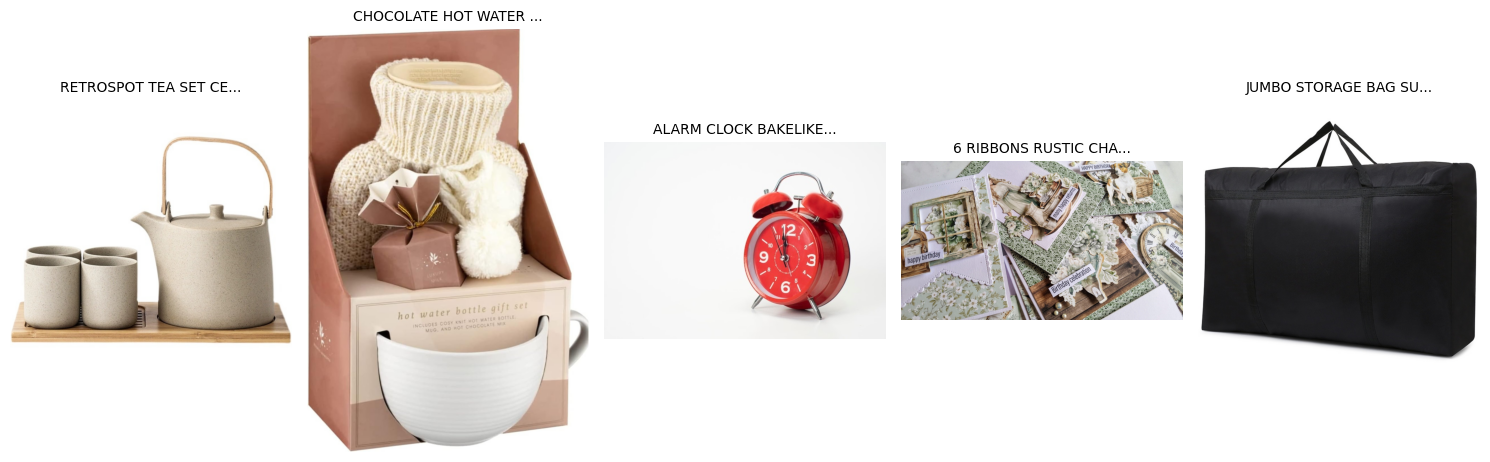

In [9]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import config # To get your IMAGE_DIR

def show_sample_images(root_dir, num_samples=5):
    all_images = []

    # 1. Walk through all folders and collect every image path
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg')):
                all_images.append(os.path.join(root, file))

    # 2. Check if we have images
    if not all_images:
        print(f"No images found in {root_dir}. Did the scraper run?")
        return

    # 3. Pick random images
    samples = random.sample(all_images, min(len(all_images), num_samples))

    # 4. Display them
    plt.figure(figsize=(15, 5)) # Width, Height
    for i, img_path in enumerate(samples):
        try:
            # Load image
            img = mpimg.imread(img_path)

            # Get the folder name (which is the product description)
            folder_name = os.path.basename(os.path.dirname(img_path))

            # Plot
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(folder_name[:20] + "...", fontsize=10) # Truncate long names
            plt.axis('off')
        except Exception as e:
            print(f"Could not load {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Run the function
show_sample_images(config.IMAGE_DIR, num_samples=5)

In [10]:
%%writefile ocr_service.py
import cv2
import pytesseract
import os
import sys

class OCRProcessor:
    def __init__(self):
        # Tesseract is usually found automatically on Linux/Colab.
        # If on Windows, you might need to uncomment and set the path:
        # pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
        pass

    def extract_text(self, image_path):
        """Loads an image, applies preprocessing, and extracts text."""

        # 1. Validation
        if not os.path.exists(image_path):
            return f"Error: Image not found at {image_path}"

        # 2. Load Image
        image = cv2.imread(image_path)
        if image is None:
            return "Error: Could not read image format."

        # 3. Preprocessing (Critical for Accuracy)
        # Convert to Grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Thresholding (Binarization)
        # This converts the image to strict Black & White, removing shadows/noise
        # Otsu's method automatically finds the best separation point.
        processed_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # 4. Extract Text
        try:
            text = pytesseract.image_to_string(processed_img)
            return text.strip()
        except Exception as e:
            return f"OCR Error: {e}"

# --- TEST EXECUTION ---
if __name__ == "__main__":
    ocr = OCRProcessor()

    # Replace this with an actual image path you have uploaded to your environment
    test_path = '/content/WhatsApp Image 2025-02-20 at 01.47.25.jpeg.jpg'

    if os.path.exists(test_path):
        print(f"Processing {test_path}...")
        result = ocr.extract_text(test_path)
        print("\n--- Extracted Text ---")
        print(result)
    else:
        print(f"Test image not found at: {test_path}")
        print("Please upload an image and update the path to test.")

Writing ocr_service.py


## 3. search_engine.py
This handles the Pinecone Vector Database logic.

In [16]:
%%writefile search_engine.py
import pandas as pd
import time
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import config

class VectorDBManager:
    def __init__(self, api_key, index_name):
        self.pc = Pinecone(api_key=api_key)
        self.index_name = index_name
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.index = None

    def setup_index(self):
        """Creates the Pinecone index if it doesn't exist."""
        existing_indexes = [i.name for i in self.pc.list_indexes()]

        if self.index_name not in existing_indexes:
            print(f"Creating index: {self.index_name}...")
            self.pc.create_index(
                name=self.index_name,
                dimension=384,
                metric='cosine',
                spec=ServerlessSpec(cloud='aws', region='us-east-1')
            )
            # Wait for index to be ready
            time.sleep(10)

        self.index = self.pc.Index(self.index_name)
        return self.index

    def vectorize_and_upsert(self, df):
        """Batches data, converts to vectors, and uploads to Pinecone."""
        if self.index is None:
            self.setup_index()

        print(f"Starting ingestion of raw data: {len(df)} rows...")

        # 1. Deduplicate by Description (we only need one vector per product type)
        # Ensure we don't have empty descriptions
        df = df.dropna(subset=['Description'])
        unique_products = df.drop_duplicates(subset=['Description']).copy()

        print(f"Unique products to vectorize: {len(unique_products)}")

        batch_size = 100
        total_rows = len(unique_products)

        # 2. Loop through data in batches
        for i in tqdm(range(0, total_rows, batch_size), desc="Upserting"):
            batch = unique_products.iloc[i : i + batch_size]

            # A. Convert Text to Vectors
            descriptions = batch['Description'].astype(str).tolist()
            embeddings = self.model.encode(descriptions).tolist()

            # B. Prepare Metadata
            # Ensure StockCode is a string for the ID
            ids = batch['StockCode'].astype(str).tolist()

            # Create metadata dicts
            metadatas = batch[['Description', 'UnitPrice', 'Country']].to_dict('records')

            # C. Zip it all together: (ID, Vector, Metadata)
            vectors_to_upsert = list(zip(ids, embeddings, metadatas))

            # D. Upload to Pinecone
            self.index.upsert(vectors=vectors_to_upsert)

        print("Ingestion complete!")

    def query_product(self, query_text, top_k=5):
        """Search the database."""
        if self.index is None:
            self.setup_index()

        query_vector = self.model.encode(query_text).tolist()
        result = self.index.query(vector=query_vector, top_k=top_k, include_metadata=True)
        return result

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Initialize
    vdb = VectorDBManager(config.PINECONE_API_KEY, config.INDEX_NAME)
    vdb.setup_index()

    # 2. Load Data
    try:
        print(f"Loading data from {config.CLEAN_DATA_PATH}...")
        df_clean = pd.read_csv(config.CLEAN_DATA_PATH)
        df_clean['Description'] = df_clean['Description'].astype(str)
        df_clean['StockCode'] = df_clean['StockCode'].astype(str)

        # 3. Ask User to Upload
        choice = input("Do you want to upload vectors to Pinecone? (yes/no): ")
        if choice.lower() in ['yes', 'y']:
            vdb.vectorize_and_upsert(df_clean)

        # 4. Test Search
        print("\n--- Testing Search Engine ---")
        test_query = "white hanging heart"
        results = vdb.query_product(test_query)

        # FIX: Handling Pinecone v3+ Response Objects
        # We check if 'matches' exists as an attribute (dot notation) or key
        matches = getattr(results, 'matches', []) or results.get('matches', [])

        if matches:
            for match in matches:
                # FIX: Access properties with Dot Notation for v3+ Client
                # (We use getattr to be safe if it falls back to a dict)
                score = getattr(match, 'score', None) or match.get('score')
                metadata = getattr(match, 'metadata', {}) or match.get('metadata', {})

                # Handle cases where metadata is None
                if metadata:
                    description = metadata.get('Description', 'Unknown Description')
                else:
                    description = "No Metadata Found"

                print(f"Score: {score:.4f} | {description}")
        else:
            print("No matches found.")

    except FileNotFoundError:
        print(f"Error: Could not find {config.CLEAN_DATA_PATH}. Run data_pipeline.py first.")
    # Commented out the generic catch so you can see the REAL error line if it fails again
    # except Exception as e:
    #     print(f"An unexpected error occurred: {e}")

Overwriting search_engine.py


In [17]:
!python search_engine.py

2025-12-15 06:45:39.078050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765781139.098193    7498 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765781139.104326    7498 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765781139.120873    7498 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781139.120899    7498 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781139.120905    7498 computation_placer.cc:177] computation placer alr

## 4. vision_model.py
This contains the Transfer Learning model (MobileNetV2) logic.

In [18]:
%%writefile experiment_tracker.py
import csv
import os
from datetime import datetime
import json

class ExperimentTracker:
    def __init__(self, log_file='experiments.csv'):
        self.log_file = log_file
        self._initialize_log()

    def _initialize_log(self):
        """Create CSV file with headers if it doesn't exist"""
        if not os.path.exists(self.log_file):
            with open(self.log_file, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([
                    'experiment_id',
                    'date',
                    'model_type',
                    'base_frozen',
                    'dropout_rate',
                    'dense_units',
                    'l2_regularization',
                    'learning_rate',
                    'batch_size',
                    'augmentation',
                    'final_train_acc',
                    'final_val_acc',
                    'test_acc',
                    'train_val_gap',
                    'overfitting_score',
                    'epochs_trained',
                    'notes'
                ])
            print(f"✅ Created experiment log: {self.log_file}")

    def log_experiment(self, model_config, history, test_accuracy=None, notes=""):
        """
        Log an experiment to CSV

        Args:
            model_config: dict with model configuration
            history: Keras training history object
            test_accuracy: float, test set accuracy (optional)
            notes: str, additional notes about the experiment
        """
        # Generate experiment ID
        exp_id = f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

        # Extract metrics from history
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        train_val_gap = final_train_acc - final_val_acc
        epochs_trained = len(history.history['accuracy'])

        # Calculate overfitting score (higher = worse overfitting)
        overfitting_score = train_val_gap * 100  # As percentage

        # Prepare row data
        row = [
            exp_id,
            datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            model_config.get('model_type', 'MobileNetV2'),
            model_config.get('base_frozen', True),
            model_config.get('dropout_rate', 0.3),
            model_config.get('dense_units', 128),
            model_config.get('l2_reg', 0.001),
            model_config.get('learning_rate', 0.001),
            model_config.get('batch_size', 32),
            model_config.get('augmentation_level', 'moderate'),
            f"{final_train_acc:.4f}",
            f"{final_val_acc:.4f}",
            f"{test_accuracy:.4f}" if test_accuracy else "N/A",
            f"{train_val_gap:.4f}",
            f"{overfitting_score:.2f}",
            epochs_trained,
            notes
        ]

        # Append to CSV
        with open(self.log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(row)

        # Print summary
        print("\n" + "="*70)
        print(f"📊 EXPERIMENT LOGGED: {exp_id}")
        print("="*70)
        print(f"Training Accuracy:   {final_train_acc:.2%}")
        print(f"Validation Accuracy: {final_val_acc:.2%}")
        if test_accuracy:
            print(f"Test Accuracy:       {test_accuracy:.2%}")
        print(f"Train-Val Gap:       {train_val_gap:.2%} {'⚠️ OVERFITTING!' if train_val_gap > 0.15 else '✅ Good'}")
        print(f"Epochs Trained:      {epochs_trained}")
        print(f"Notes:               {notes}")
        print("="*70)
        print(f"✅ Logged to {self.log_file}\n")

        return exp_id

    def view_experiments(self, top_n=10, sort_by='test_acc'):
        """
        View experiment results

        Args:
            top_n: int, number of experiments to show
            sort_by: str, column to sort by ('test_acc', 'val_acc', 'train_val_gap')
        """
        if not os.path.exists(self.log_file):
            print("No experiments logged yet!")
            return

        import pandas as pd
        df = pd.read_csv(self.log_file)

        # Convert to float for sorting
        df['test_acc'] = pd.to_numeric(df['test_acc'], errors='coerce')
        df['final_val_acc'] = pd.to_numeric(df['final_val_acc'], errors='coerce')
        df['train_val_gap'] = pd.to_numeric(df['train_val_gap'], errors='coerce')

        # Sort
        if sort_by == 'train_val_gap':
            df_sorted = df.sort_values(sort_by, ascending=True)  # Lower is better
        else:
            df_sorted = df.sort_values(sort_by, ascending=False)  # Higher is better

        print("\n" + "="*100)
        print(f"📈 TOP {top_n} EXPERIMENTS (sorted by {sort_by})")
        print("="*100)

        # Select key columns
        display_cols = [
            'experiment_id', 'date', 'dropout_rate', 'learning_rate',
            'final_train_acc', 'final_val_acc', 'test_acc',
            'train_val_gap', 'epochs_trained', 'notes'
        ]

        print(df_sorted[display_cols].head(top_n).to_string(index=False))
        print("="*100 + "\n")

        return df_sorted

    def compare_experiments(self, exp_ids):
        """Compare specific experiments side by side"""
        import pandas as pd
        df = pd.read_csv(self.log_file)

        comparison = df[df['experiment_id'].isin(exp_ids)]

        if len(comparison) == 0:
            print("No matching experiments found!")
            return

        print("\n" + "="*100)
        print("🔍 EXPERIMENT COMPARISON")
        print("="*100)
        print(comparison.to_string(index=False))
        print("="*100 + "\n")

        return comparison

    def get_best_experiment(self, metric='test_acc'):
        """Get the best performing experiment"""
        import pandas as pd
        df = pd.read_csv(self.log_file)

        # Convert to float
        df[metric] = pd.to_numeric(df[metric], errors='coerce')

        if metric == 'train_val_gap':
            best = df.loc[df[metric].idxmin()]  # Lower is better
        else:
            best = df.loc[df[metric].idxmax()]  # Higher is better

        print("\n" + "="*70)
        print(f"🏆 BEST EXPERIMENT (by {metric})")
        print("="*70)
        for key, value in best.items():
            print(f"{key:20s}: {value}")
        print("="*70 + "\n")

        return best


# Convenience function
def log_experiment(model_config, history, test_accuracy=None, notes=""):
    """Quick function to log an experiment"""
    tracker = ExperimentTracker()
    return tracker.log_experiment(model_config, history, test_accuracy, notes)


def view_experiments(top_n=10, sort_by='test_acc'):
    """Quick function to view experiments"""
    tracker = ExperimentTracker()
    return tracker.view_experiments(top_n, sort_by)


def get_best_experiment(metric='test_acc'):
    """Quick function to get best experiment"""
    tracker = ExperimentTracker()
    return tracker.get_best_experiment(metric)

Writing experiment_tracker.py


In [19]:
!python experiment_tracker.py

In [20]:
%%writefile vision_model.py
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import config
from experiment_tracker import ExperimentTracker  # ADD THIS

class ProductClassifier:
    def __init__(self):
        self.model = None
        self.classes = None
        self.tracker = ExperimentTracker()  # ADD THIS

    def train(self, experiment_notes=""):
        """Trains the model with BALANCED regularization."""

        # Store configuration for logging
        model_config = {
            'model_type': 'MobileNetV2',
            'base_frozen': True,  # Change if you unfreeze base
            'dropout_rate': 0.3,
            'dense_units': 128,
            'l2_reg': 0.001,
            'learning_rate': 0.001,
            'batch_size': config.BATCH_SIZE,
            'augmentation_level': 'moderate'
        }

        # 1. MODERATE Data Augmentation (was too aggressive)
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,      # Reduced from 40
            width_shift_range=0.15, # Reduced from 0.3
            height_shift_range=0.15,
            zoom_range=0.15,        # Reduced from 0.3
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )

        print("Preparing data generators...")
        train_gen = train_datagen.flow_from_directory(
            config.IMAGE_DIR, target_size=config.IMG_SIZE,
            batch_size=config.BATCH_SIZE, subset='training',
            class_mode='categorical'
        )

        val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
        val_gen = val_datagen.flow_from_directory(
            config.IMAGE_DIR, target_size=config.IMG_SIZE,
            batch_size=config.BATCH_SIZE, subset='validation',
            class_mode='categorical'
        )

        self.classes = list(train_gen.class_indices.keys())
        with open(config.CLASS_NAMES_FILE, 'wb') as f:
            pickle.dump(self.classes, f)

        print(f"Found {len(self.classes)} classes: {self.classes}")
        print(f"Training samples: {train_gen.samples}")
        print(f"Validation samples: {val_gen.samples}")

        # 2. Build Model with REDUCED Regularization
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=config.IMG_SIZE + (3,))

        # OPTION 1: Keep base frozen initially (safer for small datasets)
        base_model.trainable = False

        # OPTION 2: Unfreeze base (try this if Option 1 still fails)
        # base_model.trainable = True
        # model_config['base_frozen'] = False  # Update config if you unfreeze

        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        # REDUCED regularization
        x = Dropout(0.3)(x)  # Reduced from 0.5
        x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Increased units, reduced L2
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)  # Reduced from 0.5

        outputs = Dense(len(self.classes), activation='softmax')(x)

        self.model = Model(inputs=base_model.input, outputs=outputs)

        # Standard learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Increased from 0.0005
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # 3. Callbacks with more patience
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
        ]

        print("\n=== Starting Training ===")
        print("Model summary:")
        self.model.summary()

        history = self.model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=50,  # More epochs since we have early stopping
            callbacks=callbacks,
            verbose=1
        )

        self.model.save(config.MODEL_PATH)
        print(f"\nModel saved to {config.MODEL_PATH}")

        # Print final metrics
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
        print(f"Final Validation Accuracy: {final_val_acc:.4f}")

        self.plot_performance(history)

        # NEW: Log experiment (without test accuracy yet)
        exp_id = self.tracker.log_experiment(
            model_config=model_config,
            history=history,
            test_accuracy=None,  # Will add later from evaluate_model.py
            notes=experiment_notes
        )

        print(f"\n✅ Experiment logged as: {exp_id}")
        print("💡 Run evaluate_model.py to get test accuracy and update the log!")

        return history

    def plot_performance(self, history):
        """Plots accuracy and loss graphs."""
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(acc))

        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
        plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--', linewidth=2)
        plt.legend(loc='lower right')
        plt.title('Accuracy Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
        plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--', linewidth=2)
        plt.legend(loc='upper right')
        plt.title('Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('training_performance.png', dpi=300)
        print("Performance plots saved to 'training_performance.png'")

if __name__ == "__main__":
    classifier = ProductClassifier()
    if os.path.exists(config.IMAGE_DIR):
        # Add notes about this experiment
        notes = "Baseline with moderate augmentation, frozen base, dropout 0.3"
        classifier.train(experiment_notes=notes)
    else:
        print(f"Error: Image directory '{config.IMAGE_DIR}' not found.")

Writing vision_model.py


In [21]:
!python vision_model.py

2025-12-15 06:48:05.090827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765781285.108837    8162 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765781285.114398    8162 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765781285.128585    8162 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781285.128609    8162 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781285.128613    8162 computation_placer.cc:177] computation placer alr

In [22]:
%%writefile evaluate_model.py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import config
import os
import csv
from datetime import datetime

def update_experiment_with_test_accuracy(test_accuracy):
    """Update the most recent experiment with test accuracy"""
    log_file = 'experiments.csv'

    if not os.path.exists(log_file):
        print("⚠️ No experiment log found. Train a model first!")
        return

    # Read all experiments
    rows = []
    with open(log_file, 'r') as f:
        reader = csv.reader(f)
        headers = next(reader)
        rows = list(reader)

    if len(rows) == 0:
        print("⚠️ No experiments logged yet!")
        return

    # Update the most recent experiment (last row)
    last_row = rows[-1]
    test_acc_index = headers.index('test_acc')
    last_row[test_acc_index] = f"{test_accuracy:.4f}"
    rows[-1] = last_row

    # Write back
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(rows)

    exp_id = last_row[0]  # First column is experiment_id
    print(f"\n✅ Updated experiment {exp_id} with test accuracy: {test_accuracy:.2%}")

def evaluate():
    # 1. Check if model exists
    if not os.path.exists(config.MODEL_PATH):
        print(f"Error: Model not found at {config.MODEL_PATH}. Train it first!")
        return

    print("Loading model...")
    model = load_model(config.MODEL_PATH)

    # 2. Prepare Data Generator (Use the same split as training)
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    print("Loading test data (from validation split)...")
    test_gen = test_datagen.flow_from_directory(
        config.IMAGE_DIR,
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # 3. Run Evaluation
    print("\n--- Calculating Accuracy ---")
    loss, accuracy = model.evaluate(test_gen)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    # 4. Update experiment log with test accuracy
    update_experiment_with_test_accuracy(accuracy)

    # 5. Generate Predictions for Confusion Matrix
    print("\n--- Generating Confusion Matrix ---")
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # 6. Classification Report (Precision & Recall)
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("\nClassification Report:")
    print(report)

    # 7. Plot Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Test Acc: {accuracy:.2%})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    print("\n✅ Confusion Matrix saved to 'confusion_matrix.png'")
    plt.show()

    # 8. Show performance summary
    print("\n" + "="*60)
    print("📊 FINAL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Test Accuracy:  {accuracy:.2%}")
    print(f"Test Loss:      {loss:.4f}")
    print("="*60)

    return accuracy

if __name__ == "__main__":
    evaluate()

Writing evaluate_model.py


In [23]:
!python evaluate_model.py

2025-12-15 06:53:16.934445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765781596.969248   10166 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765781596.979100   10166 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765781597.003434   10166 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781597.003490   10166 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781597.003500   10166 computation_placer.cc:177] computation placer alr

In [24]:
%%writefile view_experiments.py
"""
Quick script to view and analyze your experiments
Usage:
    python view_experiments.py              # View top 10 experiments
    python view_experiments.py --all        # View all experiments
    python view_experiments.py --best       # Show best experiment
"""

from experiment_tracker import ExperimentTracker
import sys

def main():
    tracker = ExperimentTracker()

    if '--best' in sys.argv:
        print("\n🏆 BEST BY TEST ACCURACY:")
        tracker.get_best_experiment(metric='test_acc')

        print("\n✅ BEST BY LEAST OVERFITTING:")
        tracker.get_best_experiment(metric='train_val_gap')

    elif '--all' in sys.argv:
        tracker.view_experiments(top_n=100)

    else:
        # Default: show top 10 by test accuracy
        tracker.view_experiments(top_n=10, sort_by='test_acc')

        print("\n💡 TIPS:")
        print("  - Use 'python view_experiments.py --best' to see best experiments")
        print("  - Use 'python view_experiments.py --all' to see all experiments")
        print("  - Check 'experiments.csv' for full details")

if __name__ == "__main__":
    main()

Writing view_experiments.py


In [25]:
!python view_experiments.py


📈 TOP 10 EXPERIMENTS (sorted by test_acc)
      experiment_id                date  dropout_rate  learning_rate  final_train_acc  final_val_acc  test_acc  train_val_gap  epochs_trained                                                         notes
exp_20251215_065204 2025-12-15 06:52:04           0.3          0.001            0.984         0.8475    0.8475         0.1365              50 Baseline with moderate augmentation, frozen base, dropout 0.3


💡 TIPS:
  - Use 'python view_experiments.py --best' to see best experiments
  - Use 'python view_experiments.py --all' to see all experiments
  - Check 'experiments.csv' for full details


In [26]:
%%writefile plot_experiments.py
"""
Visualize your experiments with beautiful charts
Usage: python plot_experiments.py
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_experiments():
    """Create visualization dashboard of all experiments"""

    if not os.path.exists('experiments.csv'):
        print("❌ No experiments.csv found. Run training first!")
        return

    # Load data
    df = pd.read_csv('experiments.csv')

    # Convert to numeric
    numeric_cols = ['dropout_rate', 'learning_rate', 'final_train_acc',
                    'final_val_acc', 'test_acc', 'train_val_gap', 'epochs_trained']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove rows with missing test_acc
    df_complete = df[df['test_acc'].notna()].copy()

    if len(df_complete) == 0:
        print("⚠️ No experiments with test accuracy yet. Run evaluate_model.py!")
        return

    print(f"📊 Visualizing {len(df_complete)} experiments...")

    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (16, 12)

    # Create subplot layout
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('🔬 Experiment Analysis Dashboard', fontsize=20, fontweight='bold', y=0.995)

    # 1. Accuracy Comparison
    ax1 = axes[0, 0]
    x = range(len(df_complete))
    ax1.plot(x, df_complete['final_train_acc'], 'o-', label='Train', linewidth=2, markersize=8)
    ax1.plot(x, df_complete['final_val_acc'], 's-', label='Validation', linewidth=2, markersize=8)
    ax1.plot(x, df_complete['test_acc'], '^-', label='Test', linewidth=2, markersize=8)
    ax1.set_xlabel('Experiment Number', fontsize=11)
    ax1.set_ylabel('Accuracy', fontsize=11)
    ax1.set_title('Accuracy Across Experiments', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # 2. Overfitting Analysis
    ax2 = axes[0, 1]
    colors = ['green' if gap < 0.10 else 'orange' if gap < 0.20 else 'red'
              for gap in df_complete['train_val_gap']]
    ax2.bar(range(len(df_complete)), df_complete['train_val_gap'], color=colors, alpha=0.7)
    ax2.axhline(y=0.15, color='red', linestyle='--', linewidth=2, label='15% threshold')
    ax2.axhline(y=0.10, color='orange', linestyle='--', linewidth=2, label='10% threshold')
    ax2.set_xlabel('Experiment Number', fontsize=11)
    ax2.set_ylabel('Train-Val Gap (Overfitting)', fontsize=11)
    ax2.set_title('Overfitting Score by Experiment', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Dropout vs Performance
    ax3 = axes[1, 0]
    scatter = ax3.scatter(df_complete['dropout_rate'], df_complete['test_acc'],
                         c=df_complete['train_val_gap'], cmap='RdYlGn_r',
                         s=200, alpha=0.7, edgecolors='black', linewidth=1.5)
    ax3.set_xlabel('Dropout Rate', fontsize=11)
    ax3.set_ylabel('Test Accuracy', fontsize=11)
    ax3.set_title('Dropout Rate vs Test Accuracy', fontsize=13, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Overfitting', fontsize=10)
    ax3.grid(True, alpha=0.3)

    # 4. Learning Rate vs Performance
    ax4 = axes[1, 1]
    scatter2 = ax4.scatter(df_complete['learning_rate'], df_complete['test_acc'],
                          c=df_complete['epochs_trained'], cmap='viridis',
                          s=200, alpha=0.7, edgecolors='black', linewidth=1.5)
    ax4.set_xlabel('Learning Rate', fontsize=11)
    ax4.set_ylabel('Test Accuracy', fontsize=11)
    ax4.set_title('Learning Rate vs Test Accuracy', fontsize=13, fontweight='bold')
    ax4.set_xscale('log')
    cbar2 = plt.colorbar(scatter2, ax=ax4)
    cbar2.set_label('Epochs', fontsize=10)
    ax4.grid(True, alpha=0.3)

    # 5. Training Efficiency (Epochs vs Accuracy)
    ax5 = axes[2, 0]
    ax5.scatter(df_complete['epochs_trained'], df_complete['test_acc'],
               s=200, alpha=0.7, edgecolors='black', linewidth=1.5, color='purple')
    ax5.set_xlabel('Epochs Trained', fontsize=11)
    ax5.set_ylabel('Test Accuracy', fontsize=11)
    ax5.set_title('Training Efficiency (Fewer epochs = better)', fontsize=13, fontweight='bold')
    ax5.grid(True, alpha=0.3)

    # 6. Performance Distribution
    ax6 = axes[2, 1]
    metrics = ['Train', 'Val', 'Test']
    means = [df_complete['final_train_acc'].mean(),
             df_complete['final_val_acc'].mean(),
             df_complete['test_acc'].mean()]
    colors_bars = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax6.bar(metrics, means, color=colors_bars, alpha=0.7, edgecolor='black', linewidth=2)
    ax6.set_ylabel('Mean Accuracy', fontsize=11)
    ax6.set_title('Average Performance Across All Experiments', fontsize=13, fontweight='bold')
    ax6.set_ylim([0, 1])
    ax6.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('experiment_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✅ Visualization saved to 'experiment_analysis.png'")

    # Print summary statistics
    print("\n" + "="*70)
    print("📈 SUMMARY STATISTICS")
    print("="*70)
    print(f"Total Experiments:      {len(df_complete)}")
    print(f"Best Test Accuracy:     {df_complete['test_acc'].max():.2%}")
    print(f"Average Test Accuracy:  {df_complete['test_acc'].mean():.2%}")
    print(f"Lowest Overfitting:     {df_complete['train_val_gap'].min():.2%}")
    print(f"Average Overfitting:    {df_complete['train_val_gap'].mean():.2%}")

    # Find best experiment
    best_idx = df_complete['test_acc'].idxmax()
    best_exp = df_complete.loc[best_idx]
    print("\n🏆 BEST EXPERIMENT:")
    print(f"ID:           {best_exp['experiment_id']}")
    print(f"Test Acc:     {best_exp['test_acc']:.2%}")
    print(f"Overfitting:  {best_exp['train_val_gap']:.2%}")
    print(f"Dropout:      {best_exp['dropout_rate']}")
    print(f"Notes:        {best_exp['notes']}")
    print("="*70)

    plt.show()

if __name__ == "__main__":
    plot_experiments()

Writing plot_experiments.py


In [27]:
!python plot_experiments.py

📊 Visualizing 1 experiments...
/content/plot_experiments.py:123: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/content/plot_experiments.py:124: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.savefig('experiment_analysis.png', dpi=300, bbox_inches='tight')

✅ Visualization saved to 'experiment_analysis.png'

📈 SUMMARY STATISTICS
Total Experiments:      1
Best Test Accuracy:     84.75%
Average Test Accuracy:  84.75%
Lowest Overfitting:     13.65%
Average Overfitting:    13.65%

🏆 BEST EXPERIMENT:
ID:           exp_20251215_065204
Test Acc:     84.75%
Overfitting:  13.65%
Dropout:      0.3
Notes:        Baseline with moderate augmentation, frozen base, dropout 0.3
Figure(1600x1400)


Anti-Overfitting Results:


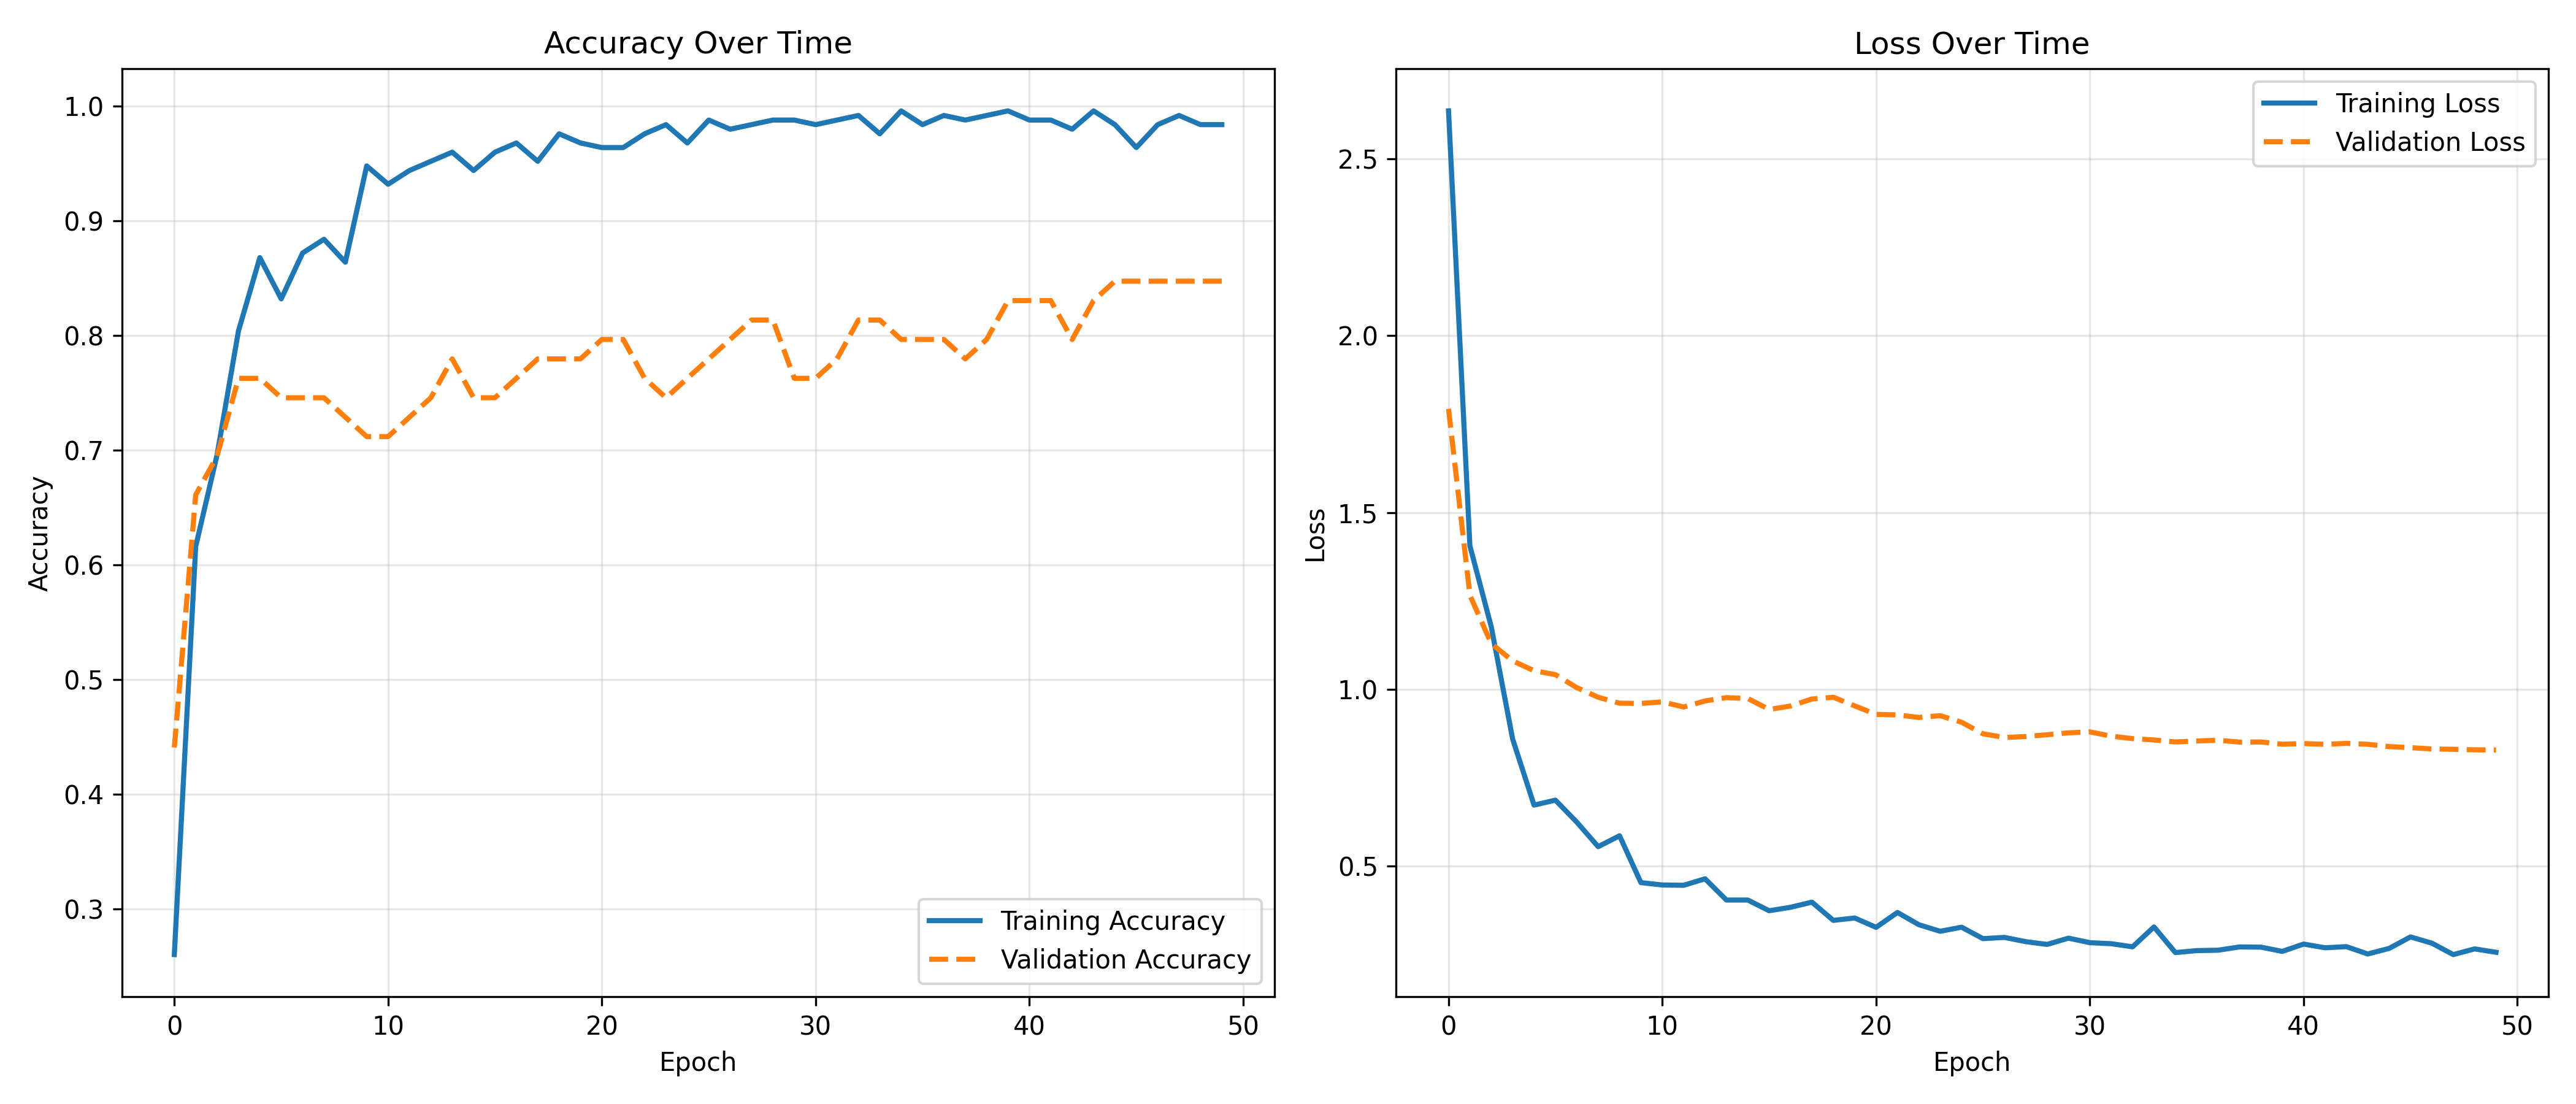

In [31]:
from IPython.display import Image, display
import os

if os.path.exists('training_performance.png'):
    print("Anti-Overfitting Results:")
    display(Image(filename='training_performance.png'))
else:
    print("Waiting for training to complete...")

## 5. app.py
The main application that ties everything together using imports.

In [29]:
%%writefile app.py
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from flask import Flask, request, render_template_string
from pyngrok import ngrok
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model

# --- CONNECTING TO YOUR PROJECT FILES ---
import config
from search_engine import VectorDBManager
from ocr_service import OCRProcessor
from vision_model import ProductClassifier

# --- GLOBAL INITIALIZATION (Run once on startup) ---
print("Initializing System Components...")

# 1. Load the Cleaned Dataset
try:
    df_clean = pd.read_csv(config.CLEAN_DATA_PATH)
    # Ensure Description column is string type for matching
    df_clean['Description'] = df_clean['Description'].astype(str)
    print(f"Dataset loaded: {len(df_clean)} products.")
except Exception as e:
    print(f"Error loading {config.CLEAN_DATA_PATH}: {e}")
    df_clean = pd.DataFrame()

# 2. Initialize Vector Database
try:
    vdb = VectorDBManager(config.PINECONE_API_KEY, config.INDEX_NAME)
    vdb.setup_index()
    print("Vector DB connected.")
except Exception as e:
    print(f"Error connecting to Vector DB: {e}")

# 3. Initialize OCR
ocr = OCRProcessor()

# 4. Initialize Vision Model
trainer = ProductClassifier()
if os.path.exists(config.MODEL_PATH):
    print("Loading Vision Model...")
    trainer.model = load_model(config.MODEL_PATH)
    if os.path.exists(config.CLASS_NAMES_FILE):
        with open(config.CLASS_NAMES_FILE, 'rb') as f:
            trainer.class_names = pickle.load(f)
else:
    print("Warning: Vision model not found.")

# --- HELPER FUNCTIONS ---

def recommend_products(query_text):
    """Searches Pinecone and returns structured data."""
    if not query_text:
        return "No query provided.", []

    try:
        results = vdb.query_product(query_text, top_k=5)
    except Exception as e:
        return f"Error querying database: {str(e)}", []

    recommendations = []

    # Handle Pinecone response format
    matches = results.get('matches', []) if isinstance(results, dict) else getattr(results, 'matches', [])

    for match in matches:
        # Extract metadata
        metadata = match.get('metadata', {}) if isinstance(match, dict) else getattr(match, 'metadata', {})
        score = match.get('score', 0) if isinstance(match, dict) else getattr(match, 'score', 0)

        # --- THE FIX IS HERE ---
        # We try 'Description' (Capital D) first, which matches your database.
        # We also try 'description' (lowercase) just in case.
        description = metadata.get('Description', metadata.get('description', 'Unknown Product'))

        # Look up Price/StockCode in our local CSV
        price = "N/A"
        stock_code = "N/A"

        # Find matching row in dataframe
        if description != "Unknown Product":
            product_row = df_clean[df_clean['Description'] == description]
            if not product_row.empty:
                price = product_row.iloc[0]['UnitPrice']
                stock_code = product_row.iloc[0]['StockCode']

        recommendations.append({
            'description': description,
            'price': price,
            'stock_code': stock_code,
            'score': round(score, 2)
        })

    response_text = f"Found {len(recommendations)} matches for '{query_text}'."
    return response_text, recommendations

def process_ocr_query(image_path):
    try:
        extracted_text = ocr.extract_text(image_path)
    except Exception as e:
        return f"OCR Error: {e}", [], ""

    if not extracted_text:
        return "No text detected.", [], ""

    response_text, recommendations = recommend_products(extracted_text)
    return response_text, recommendations, extracted_text

def predict_product_from_image(image_path):
    try:
        if trainer.model is None:
            return "Error: Vision model not loaded.", "System Error", []

        img = keras_image.load_img(image_path, target_size=config.IMG_SIZE)
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        predictions = trainer.model.predict(img_array)
        class_idx = np.argmax(predictions[0])

        predicted_class = trainer.class_names[class_idx] if trainer.class_names else "Unknown"
        response_text, recommendations = recommend_products(predicted_class)

        return predicted_class, response_text, recommendations
    except Exception as e:
        return f"Error: {str(e)}", "Could not process image", []

# --- FLASK APP SETUP ---
app = Flask(__name__)
ngrok.set_auth_token(config.NGROK_AUTH_TOKEN)
ngrok.kill()
public_url = ngrok.connect(5000).public_url
print(f" * Public URL: {public_url}")

# --- HTML TEMPLATE (YOUR EXACT DESIGN) ---
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>AI E-commerce Assistant</title>
    <style>
        body { font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; padding: 20px; background-color: #f4f4f9; }
        .container { max-width: 900px; margin: auto; background: white; padding: 30px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); }
        h1 { color: #333; text-align: center; }
        nav { text-align: center; margin-bottom: 20px; }
        nav a { margin: 0 15px; text-decoration: none; color: #007bff; font-weight: bold; font-size: 1.1em; }
        nav a:hover { text-decoration: underline; }
        .result { background: #e9ecef; padding: 20px; margin-top: 20px; border-radius: 8px; }

        /* Table Styles */
        table { width: 100%; border-collapse: collapse; margin-top: 15px; background: white; }
        th, td { padding: 12px; text-align: left; border-bottom: 1px solid #ddd; }
        th { background-color: #007bff; color: white; }
        tr:hover { background-color: #f1f1f1; }

        form { margin-top: 20px; text-align: center; }
        input[type="text"] { padding: 10px; width: 60%; border: 1px solid #ddd; border-radius: 4px; }
        button { padding: 10px 20px; background-color: #28a745; color: white; border: none; border-radius: 4px; cursor: pointer; }
        button:hover { background-color: #218838; }
    </style>
</head>
<body>
<div class="container">
    <h1>AI Product Assistant</h1>
    <nav>
        <a href="/">Text Search</a> |
        <a href="/ocr">Handwritten Search</a> |
        <a href="/vision">Image Detection</a>
    </nav>
    <hr>

    {% if page == 'text' %}
    <h2 style="text-align:center;">Find Products by Description</h2>
    <form method="post">
        <input type="text" name="query" placeholder="E.g., 'White metal lantern'..." required>
        <button type="submit">Search</button>
    </form>
    {% elif page == 'ocr' %}
    <h2 style="text-align:center;">Upload Handwritten Note</h2>
    <form method="post" enctype="multipart/form-data">
        <input type="file" name="file" required>
        <button type="submit">Upload & Read</button>
    </form>
    {% elif page == 'vision' %}
    <h2 style="text-align:center;">Upload Product Image</h2>
    <form method="post" enctype="multipart/form-data">
        <input type="file" name="file" required>
        <button type="submit">Identify Product</button>
    </form>
    {% endif %}

    {% if result %}
    <div class="result">
        <h3>Analysis Results:</h3>
        <p><strong>System Response:</strong> {{ response_text }}</p>
        {% if extracted %} <p><strong>Extracted Text:</strong> <em>"{{ extracted }}"</em></p> {% endif %}
        {% if predicted_class %} <p><strong>Detected Category:</strong> <span style="color:green; font-weight:bold;">{{ predicted_class }}</span></p> {% endif %}

        <h4>Recommended Products:</h4>
        {% if recommendations %}
        <table>
            <thead>
                <tr>
                    <th style="width: 50%;">Product Name</th>
                    <th>Stock Code</th>
                    <th>Price ($)</th>
                    <th>Relevance Score</th>
                </tr>
            </thead>
            <tbody>
                {% for item in recommendations %}
                <tr>
                    <td>{{ item.description }}</td>
                    <td>{{ item.stock_code }}</td>
                    <td>{{ item.price }}</td>
                    <td>{{ item.score }}</td>
                </tr>
                {% endfor %}
            </tbody>
        </table>
        {% else %}
        <p>No products found matching your query.</p>
        {% endif %}
        </div>
    {% endif %}
</div>
</body>
</html>
"""

# --- ROUTES ---
@app.route('/', methods=['GET', 'POST'])
def text_query():
    result = None
    response_text = ""
    recommendations = []

    if request.method == 'POST':
        query = request.form.get('query', '')
        response_text, recommendations = recommend_products(query)
        result = True

    return render_template_string(html_template, page='text', result=result, response_text=response_text, recommendations=recommendations)

@app.route('/ocr', methods=['GET', 'POST'])
def ocr_query():
    result = None
    response_text = ""
    recommendations = []
    extracted = ""

    if request.method == 'POST':
        if 'file' not in request.files:
            return "No file uploaded"
        file = request.files['file']
        if file.filename != '':
            filepath = os.path.join('static', file.filename)
            os.makedirs('static', exist_ok=True)
            file.save(filepath)

            response_text, recommendations, extracted = process_ocr_query(filepath)
            result = True

    return render_template_string(html_template, page='ocr', result=result, response_text=response_text, recommendations=recommendations, extracted=extracted)

@app.route('/vision', methods=['GET', 'POST'])
def vision_query():
    result = None
    response_text = ""
    recommendations = []
    predicted_class = ""

    if request.method == 'POST':
        if 'file' not in request.files:
            return "No file uploaded"
        file = request.files['file']
        if file.filename != '':
            filepath = os.path.join('static', file.filename)
            os.makedirs('static', exist_ok=True)
            file.save(filepath)

            predicted_class, response_text, recommendations = predict_product_from_image(filepath)
            result = True

    return render_template_string(html_template, page='vision', result=result, response_text=response_text, recommendations=recommendations, predicted_class=predicted_class)

if __name__ == '__main__':
    app.run(port=5000)

Writing app.py


In [30]:
!python app.py

2025-12-15 06:57:34.473608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765781854.493250   11363 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765781854.499240   11363 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765781854.514489   11363 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781854.514512   11363 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781854.514516   11363 computation_placer.cc:177] computation placer alr